# Import packages

In [1]:
import os
import time
import scipy
import copy
import pickle
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy import signal
import matplotlib.pyplot as plt

In [2]:
import TADGATE

In [3]:
from TADGATE import TADGATE_utils as TL
from TADGATE import Plot_Function as PF
from TADGATE import Call_TADs as CT
from TADGATE import TADGATE_main

In [2]:
#import sys
#sys.path.append('/home/dcdang/pycharm_workspace/TADGATE/TADGATE_script')
#import TADGATE_utils as TL
#import Plot_Function as PF
#import Call_TADs as CT
#import TADGATE_main

#import imp
#imp.reload(TL)
#imp.reload(PF)
#imp.reload(CT)
#imp.reload(TADGATE_main)

In [ ]:
# Please download the data used in this tutorial from https://drive.google.com/drive/folders/1B6Hp3kUgmjkm-IIIQZ7A3WR3iwEgtb0O

# Load Hi-C data

## Load chromosome size of reference genome

In [ ]:
# The users need to get the length of all chromosomes of the reference genome. We provide the chromosome size of hg19.
# You can download the chromosome size of other reference or species from UCSC.

In [4]:
chrom_size_file = '/mnt/disk2/ddc/project/TADGATE/Data_for_packages/chrom_hg19_sizes.txt'
chr_size = TL.load_chromosome_size(chrom_size_file)

In [5]:
chr_size

{'chr1': 249250621,
 'chr2': 243199373,
 'chr3': 198022430,
 'chr4': 191154276,
 'chr5': 180915260,
 'chr6': 171115067,
 'chr7': 159138663,
 'chr8': 146364022,
 'chr9': 141213431,
 'chr10': 135534747,
 'chr11': 135006516,
 'chr12': 133851895,
 'chr13': 115169878,
 'chr14': 107349540,
 'chr15': 102531392,
 'chr16': 90354753,
 'chr17': 81195210,
 'chr18': 78077248,
 'chr19': 59128983,
 'chr20': 63025520,
 'chr21': 48129895,
 'chr22': 51304566,
 'chrX': 155270560,
 'chrY': 59373566,
 'chrM': 16571}

## Load Hi-C contact maps

In [6]:
cell_type = 'GM12878'
resolution = 50000

In [7]:
data_add_dense = '/mnt/disk2/ddc/project/TADGATE/Data_for_packages/GM12878_dense'
data_add_sparse = '/mnt/disk2/ddc/project/TADGATE/Data_for_packages/GM12878_sparse'

In [8]:
# We allow input in two forms of Hi-C contact map: (1)N*N dense matrix, recording interactions between all bins. 
# (2) M*3 sparse matrix, recording the positions and values of non-zero interactions. Because the Hi-C matrix are 
# symmetric. Only the upper or lower triangular matrix need to be stored in the sparse matrix. 

In [9]:
data_add = data_add_dense

In [10]:
Files = os.listdir(data_add)
Files

['GM12878_chr8_res_50000_dense.mat',
 'GM12878_chr13_res_50000_dense.mat',
 'GM12878_chr16_res_50000_dense.mat',
 'GM12878_chrX_res_50000_dense.mat',
 'GM12878_chr11_res_50000_dense.mat',
 'GM12878_chr9_res_50000_dense.mat',
 'GM12878_chr19_res_50000_dense.mat',
 'GM12878_chr17_res_50000_dense.mat',
 'GM12878_chr4_res_50000_dense.mat',
 'GM12878_chr18_res_50000_dense.mat',
 'GM12878_chr10_res_50000_dense.mat',
 'GM12878_chr21_res_50000_dense.mat',
 'GM12878_chr5_res_50000_dense.mat',
 'GM12878_chr2_res_50000_dense.mat',
 'GM12878_chr22_res_50000_dense.mat',
 'GM12878_chr7_res_50000_dense.mat',
 'GM12878_chr14_res_50000_dense.mat',
 'GM12878_chr1_res_50000_dense.mat',
 'GM12878_chr15_res_50000_dense.mat',
 'GM12878_chr12_res_50000_dense.mat',
 'GM12878_chr6_res_50000_dense.mat',
 'GM12878_chr20_res_50000_dense.mat',
 'GM12878_chr3_res_50000_dense.mat']

In [11]:
hic_mat_all = {}
for Chr in tqdm(chr_size.keys()):
    if Chr in ['chrY', 'chrM']:
        continue
    file = cell_type + '_' + Chr + '_res_' + str(resolution) + '_dense.mat'
    mat_file = data_add + '/' + file
    chr_length = chr_size[Chr]
    bin_name_use = TL.chr_cut(chr_length, Chr, resolution)
    bin_num = len(bin_name_use)
    mat_hic = TL.LoadHicMat(mat_file, bin_num, mat_type='dense')
    # if sparse mat are used
    #mat_hic = TL.LoadHicMat(mat_file, bin_num, mat_type='sparse', mat_half = True)
    while np.max(mat_hic) <= 1000:
        mat_hic = mat_hic * 10
    while np.max(mat_hic) > 10000:
        mat_hic = mat_hic * 0.1
    hic_mat_all[Chr] = mat_hic

100%|██████████| 25/25 [00:11<00:00,  2.10it/s]


# Run TADGATE

## Run model

In [90]:
# Set GPU name

In [12]:
device_gpu0 = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_gpu1 = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device_gpu2 = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
device_gpu3 = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

device_cpu = torch.device('cpu')

In [13]:
# Paramater settings: the meanings of paramaters can be found in function 'TADGATE_main.TADGATE_for_embedding'

In [14]:
help(TADGATE_main.TADGATE_for_embedding)

Help on function TADGATE_for_embedding in module TADGATE.TADGATE_main:

TADGATE_for_embedding(hic_all, chr_size, resolution, graph_radius, split_size, device, layer_node1, layer_node2, lr, weight_decay, num_epoch, embed_attention=False, weight_use='No', weight_range=0, weight_rate=0, auto_expand=False, target_chr_l=[], scale_f=1, diag_cut=0, wd='all', seed=666, verbose=True)
    Run TADGATE on all chromosomes.
    :param hic_all:  dict, Hi-C contact maps for all chromosomes.
    :param chr_size:  dict, chromosome sizes.
    :param resolution:  int, Resolution of Hi-C contact map.
    :param graph_radius:  int, Radius used to construct spatial network.
    :param split_size:  int, Size of sub-matrices to split Hi-C contact maps into.
    :param device:  str, Device to run TADGATE on.
    :param layer_node1: int, number of nodes in first layer of autoencoder.
    :param layer_node2: int, number of nodes in second layer of autoencoder.
    :param lr:  float, Learning rate.
    :param weig

In [15]:
# Paramaters
graph_radius = 2
split_size = 'all'
device = device_gpu0 

layer_node1 = 500
layer_node2 = 100
lr = 0.001
weight_decay = 0.0001
num_epoch = 500
embed_attention = False

weight_use = 'Fix'
weight_rate = 0.3
weight_range = int(10000000 / resolution)

In [16]:
target_chr_l = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5']

In [17]:
# Run model

In [18]:
TADGATE_res_all = TADGATE_main.TADGATE_for_embedding(hic_mat_all, chr_size, resolution, graph_radius, split_size,  device, layer_node1,
                                                     layer_node2, lr, weight_decay, num_epoch, embed_attention = embed_attention, 
                                                     weight_use = weight_use, weight_range = weight_range, weight_rate = weight_rate,
                                                     target_chr_l = target_chr_l)

For chr1
Hi-C map is splited into 1 sub-map
Build spatial network...
Get mask-matrix or weight-matrix...
For No.0 sub-map
Train TADGATE....


100%|██████████| 500/500 [00:32<00:00, 15.55it/s]


For chr2
Hi-C map is splited into 1 sub-map
Build spatial network...
Get mask-matrix or weight-matrix...
For No.0 sub-map
Train TADGATE....


100%|██████████| 500/500 [00:29<00:00, 16.73it/s]


For chr3
Hi-C map is splited into 1 sub-map
Build spatial network...
Get mask-matrix or weight-matrix...
For No.0 sub-map
Train TADGATE....


100%|██████████| 500/500 [00:20<00:00, 24.85it/s]


For chr4
Hi-C map is splited into 1 sub-map
Build spatial network...
Get mask-matrix or weight-matrix...
For No.0 sub-map
Train TADGATE....


100%|██████████| 500/500 [00:19<00:00, 25.92it/s]


For chr5
Hi-C map is splited into 1 sub-map
Build spatial network...
Get mask-matrix or weight-matrix...
For No.0 sub-map
Train TADGATE....


100%|██████████| 500/500 [00:17<00:00, 28.39it/s]


Total time 126.54071879386902s


In [19]:
Chr = 'chr1'

In [20]:
TADGATE_res_all[Chr].keys()

dict_keys(['range', 'mat_split', 'row_bad', 'spatial_net', 'mat_mask', 'result'])

In [21]:
TADGATE_res_all[Chr]['result'][0].keys()

dict_keys(['loss', 'model', 'map_imputed', 'mat_imputed_sym', 'bin_rep', 'attention_map'])

## Plot loss during training process

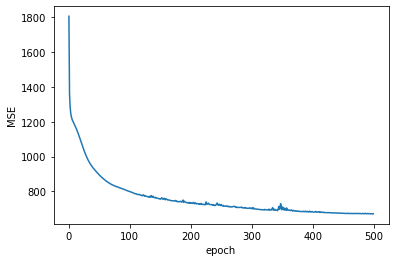

In [22]:
PF.draw_loss_record(TADGATE_res_all[Chr]['result'][0]['loss'], )

## Plot comparison of original and imputed Hi-C contact map, attention map

In [23]:
Chr = 'chr2'

In [24]:
mat_hic = copy.deepcopy(hic_mat_all[Chr])
mat_imputed = copy.deepcopy(TADGATE_res_all[Chr]['result'][0]['mat_imputed_sym'])
mat_att = copy.deepcopy(TADGATE_res_all[Chr]['result'][0]['attention_map'])

In [25]:
bin_name_l = list(TADGATE_res_all[Chr]['mat_split'][0].obs_names)
mat_list = [mat_hic, mat_imputed, mat_att]
mat_para_list = [{'color': 'Reds', 'range':[10, 90], 'diag': False, 'net': False, 'value_type':'no-real'}, 
                 {'color': 'Reds', 'range':[0, 90], 'diag': False, 'net': False, 'value_type':'no-real'},
                {'color': 'coolwarm', 'range':[0, 0.25], 'diag': True, 'net': False, 'value_type':'real'}]
title_l = ['', 'Imputed map', 'Attention map']

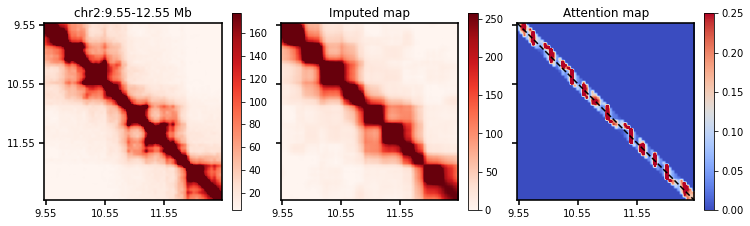

In [26]:
st = 221 - 30
ed = 221 + 30
ori = 'h'
fgsize = (12, 7)
PF.draw_multi_mat_compare(st, ed, mat_list, mat_para_list, bin_name_l, Chr, resolution, fgsize = fgsize, title_l = title_l,
                          bin_size = 20, save_name = '', ori = ori)


# Call TADs based on TADGATE results

In [27]:
# If Mclust are used, the R_HOME and R_USER need to be specified in advance
os.environ['R_HOME'] = "/home/dcdang/anaconda3/envs/Renv/lib/R"
os.environ['R_USER'] = '/home/dcdang/anaconda3/envs/TADGATE/lib/python3.8/site-packages/rpy2'

In [28]:
# Paramater settings: the meanings of paramaters can be found in function 'CT.TADGATE_call_TADs'

In [29]:
help(CT.TADGATE_call_TADs)

Help on function TADGATE_call_TADs in module TADGATE.Call_TADs:

TADGATE_call_TADs(TADGATE_embed_all, chr_size, resolution, bd_weight_list=[1.5, 1.5, 1, 1], cluster_method='Mclust', window_range=5000000, wd_p=5, dist=3, pvalue_cut=0.05, exp_length=500000, length_cut=3, contact_fold_cut=2, zero_ratio_cut=0.3, filter_method='strict', target_chr_l=[])
    Get the TADs based on the TADGATE embedding and attention map
    :param TADGATE_embed_all:  dict, the TADGATE embedding and attention map for all chromosomes
    :param chr_size: dict, the chromosome size for all chromosomes
    :param resolution: int, the resolution of the Hi-C contact map
    :param bd_weight_list: list, the weight list for different boundary score, [w_ori_CI, w_imp_CI, w_att_valley, w_clt_bd]
    :param cluster_method: str, 'Mclust', 'K-means' or 'None', the clustering method used for bin clustering
    :param window_range: int, the window size used for clustering, we split the genome into seperated windows and perfo

In [30]:
# Paramaters
bd_weight_list = [1.5, 1.5, 1, 1]
cluster_method = 'Mclust'
window_range = 5000000
wd_p = 5
dist = 3
pvalue_cut = 0.05
exp_length = 500000
length_cut = 3

In [31]:
target_chr_l = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5']

In [32]:
TADGATE_tads_all = CT.TADGATE_call_TADs(TADGATE_res_all, chr_size, resolution, bd_weight_list, 
                                        cluster_method, window_range, wd_p, dist, pvalue_cut, 
                                        exp_length, length_cut = 3, contact_fold_cut = 2, zero_ratio_cut = 0.3, 
                                        target_chr_l = target_chr_l)

For chr1


R[write to console]: Package 'mclust' version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



20% bins done!
20% bins done!
20% bins done!
20% bins done!
Running time 14.913324117660522s
For chr2
20% bins done!
20% bins done!
20% bins done!
20% bins done!
Running time 14.36380672454834s
For chr3
20% bins done!
20% bins done!
20% bins done!
20% bins done!
Running time 12.191342115402222s
For chr4
20% bins done!
20% bins done!
20% bins done!
20% bins done!
Running time 10.940731287002563s
For chr5
20% bins done!
20% bins done!
20% bins done!
20% bins done!
Running time 10.005009412765503s


In [33]:
TADGATE_tads_all['chr1'].keys()

dict_keys(['TADs', 'cluster_bin_lb', 'bin_vote_bd_score', 'bin_domain_label', 'CI_original', 'CI_imputed', 'pvalue_original', 'pvalue_imputed', 'att_profile', 'run_time'])

## Draw TADs identified by TADGATE

In [34]:
Chr = 'chr2'
mat_hic = copy.deepcopy(TADGATE_res_all[Chr]['mat_split'][0].X)
mat_imputed = copy.deepcopy(TADGATE_res_all[Chr]['result'][0]['mat_imputed_sym'])
mat_att = copy.deepcopy(TADGATE_res_all[Chr]['result'][0]['attention_map'])

In [35]:
# Extract TADs of chr2
df_tad_res = TADGATE_tads_all[Chr]['TADs'][0]
df_tad_res_only = df_tad_res[df_tad_res['type'] == 'domain']
df_tad_res_only = df_tad_res_only.reset_index(drop = True)

In [36]:
# Extract multiple score profile calculated by TADGATE
bin_vote_bd_score = TADGATE_tads_all[Chr]['bin_vote_bd_score'][0]
CI_value_ori = TADGATE_tads_all[Chr]['CI_original'][0]
pvalue_ori = TADGATE_tads_all[Chr]['pvalue_original'][0]
CI_value_imp = TADGATE_tads_all[Chr]['CI_imputed'][0]
pvalue_imp = TADGATE_tads_all[Chr]['pvalue_imputed'][0]
att_profile_smooth = TADGATE_tads_all[Chr]['att_profile'][0]

In [37]:
# Find CI peaks or attention valleys
dist = 3
CI_peak_ori = signal.find_peaks(CI_value_ori, distance=dist)[0]
CI_peak_imp = signal.find_peaks(CI_value_imp, distance=dist)[0]
Att_valley = signal.find_peaks(-np.array(att_profile_smooth), distance=dist)[0]

In [38]:
df_value_multi = pd.DataFrame()
df_value_multi['ori_pvalue'] = pvalue_ori
df_value_multi['ori_CI'] = CI_value_ori
df_value_multi['imp_pvalue'] = pvalue_imp
df_value_multi['imp_CI'] = CI_value_imp
df_value_multi['bin_vote_bd_score'] = bin_vote_bd_score
df_value_multi['attention'] = att_profile_smooth

In [39]:
value_peak_multi = {}
value_peak_multi['ori_CI'] = CI_peak_ori
value_peak_multi['imp_CI'] = CI_peak_imp
value_peak_multi['attention'] = Att_valley

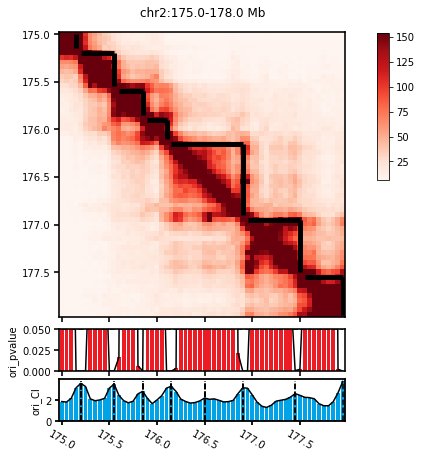

In [40]:
# Original Hi-C, TADs, original CI and original p-value
st = 3500
ed = 3560
start_bin = 0
TAD_l = TL.get_tad_list_in_target_ranges(st, ed, df_tad_res_only, resolution, start_bin, pos_type='bin')
#TAD_l = [] 
value_l = [ 'ori_pvalue', 'ori_CI',]
#value_peak_multi = ''
save_name = ''
PF.draw_map_multi_CI(mat_hic, Chr, st, ed, bin_name_l, df_value_multi, value_l, value_peak_multi, 
                     resolution, save_name = save_name, p_cut = [0.05], target_site = [], bin_size = 10, 
                     TAD_l = TAD_l, color_multi = True, h_range = (10, 90))

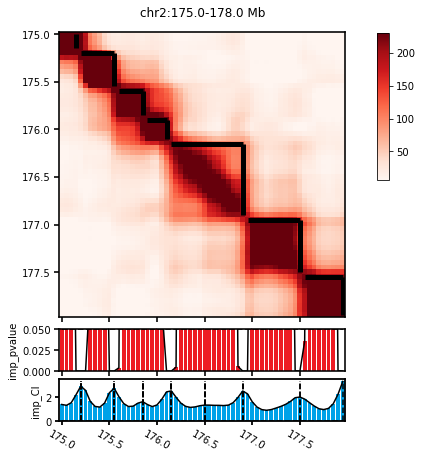

In [41]:
# Imputed Hi-C, TADs, imputed CI and imputed p-value
st = 3500
ed = 3560
start_bin = 0
TAD_l = TL.get_tad_list_in_target_ranges(st, ed, df_tad_res_only, resolution, start_bin, pos_type='bin')
#TAD_l = [] 
value_l = [ 'imp_pvalue', 'imp_CI',]
#value_peak_multi = ''
save_name = ''
PF.draw_map_multi_CI(mat_imputed, Chr, st, ed, bin_name_l, df_value_multi, value_l, value_peak_multi, 
                     resolution, save_name = save_name, p_cut = [0.05], target_site = [], bin_size = 10, 
                     TAD_l = TAD_l, color_multi = True, h_range = (10, 90))

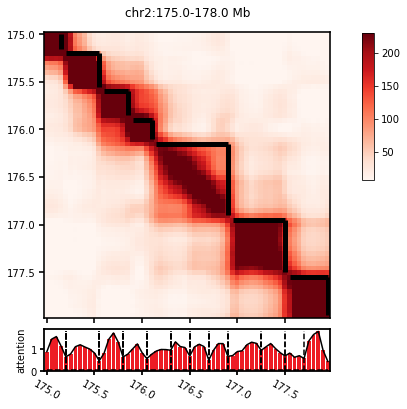

In [42]:
# Imputed Hi-C, TADs, attention
st = 3500
ed = 3560
start_bin = 0
TAD_l = TL.get_tad_list_in_target_ranges(st, ed, df_tad_res_only, resolution, start_bin, pos_type='bin')
#TAD_l = [] 
value_l = ['attention']
#value_peak_multi = ''
save_name = ''
PF.draw_map_multi_CI(mat_imputed, Chr, st, ed, bin_name_l, df_value_multi, value_l, value_peak_multi, 
                     resolution, save_name = save_name, p_cut = [0.05], target_site = [], bin_size = 10, 
                     TAD_l = TAD_l, color_multi = True, h_range = (10, 90))

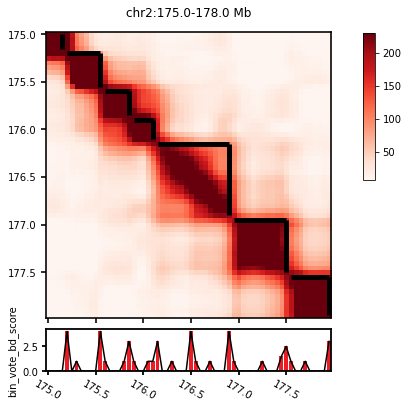

In [43]:
# Imputed Hi-C, TADs, bin_vote_bd_score
st = 3500
ed = 3560
start_bin = 0
TAD_l = TL.get_tad_list_in_target_ranges(st, ed, df_tad_res_only, resolution, start_bin, pos_type='bin')
#TAD_l = [] 
value_l = ['bin_vote_bd_score']
#value_peak_multi = ''
save_name = ''
PF.draw_map_multi_CI(mat_imputed, Chr, st, ed, bin_name_l, df_value_multi, value_l, value_peak_multi, 
                     resolution, save_name = save_name, p_cut = [0.05], target_site = [], bin_size = 10, 
                     TAD_l = TAD_l, color_multi = True, h_range = (10, 90))

## Draw attention vallys and attention peaks aggregrated Hi-C map

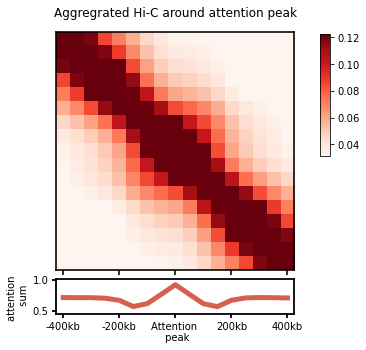

In [44]:
# Attention peak
expand = 8
pos_type = 'attention peak'
map_type = 'Hi-C'
dist = 5
mat_combine, vec_combine, count_combine = PF.get_attention_valley_peak_nearby_map(TADGATE_res_all, TADGATE_tads_all, 
                                                                                  expand, pos_type, map_type, dist)

mat_combine_mean = mat_combine / count_combine
vec_combine_mean = vec_combine / count_combine
mat_color = 'Reds'
fgsize = (5, 6)
save_name = ''
PF.draw_map_profile(map_type, pos_type, mat_combine_mean, vec_combine_mean, resolution, mat_color,
                    fgsize, save_name = '', tick_adj=True)

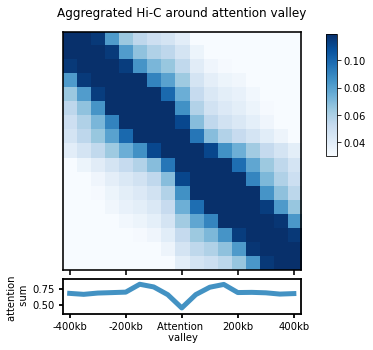

In [45]:
# Attention valley
expand = 8
pos_type = 'attention valley'
map_type = 'Hi-C'
dist = 5
mat_combine, vec_combine, count_combine = PF.get_attention_valley_peak_nearby_map(TADGATE_res_all, TADGATE_tads_all, 
                                                                                  expand, pos_type, map_type, dist)

mat_combine_mean = mat_combine / count_combine
vec_combine_mean = vec_combine / count_combine
mat_color = 'Blues'
fgsize = (5, 6)
save_name = ''
PF.draw_map_profile(map_type, pos_type, mat_combine_mean, vec_combine_mean, resolution, mat_color,
                 fgsize, save_name = '', tick_adj=True)

## Draw TADs and bin embeddings learned by TADGATE

In [46]:
embed_all = {}
embed_all['TADGATE'] = TADGATE_res_all

tads_res = {}
tads_res['TADGATE'] = TADGATE_tads_all

19


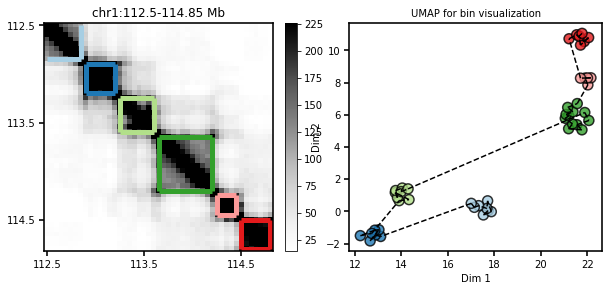

In [47]:
Chr = 'chr1'
st = 2250
ed = 2297
#st = 1253
#ed = 1300
method_rep = 'TADGATE'
method = 'TADGATE'
fgsize = (10, 4.2)
save_name = ''
for random_state in range(19, 20):
    bin_lb, TAD_l, df_bin_scatter_use, color_use = PF.hic_tad_and_bin_rep_compare(random_state, Chr, st, ed, hic_mat_all, resolution, tads_res, embed_all, method_rep, method, 
                                                                                  rd_method = 'UMAP', rd_dim = True, fgsize = fgsize, col_num = 2, arrow_draw = False, 
                                                                                  save_name = save_name)

# Apply TADGATE to sparse Hi-C contact maps of tissues

## For Lung

In [48]:
data_add_tissue = '/mnt/disk2/ddc/project/TADGATE/Data_for_packages' 

In [49]:
cell_type = 'Lung'
resolution = 40000
Chr = 'chr2'

In [50]:
# Load Hi-c data

In [51]:
hic_mat_lung = {}
mat_file = data_add_tissue + '/' + 'Lung_chr2_40kb_iced.mat'
chr_length = chr_size[Chr]
bin_name_use = TL.chr_cut(chr_length, Chr, resolution)
bin_num = len(bin_name_use)
mat_hic = TL.LoadHicMat(mat_file, bin_num, mat_type='dense')
while np.max(mat_hic) <= 1000:
    mat_hic = mat_hic * 10
#while np.max(mat_hic) > 10000:
    #mat_hic = mat_hic * 0.1
hic_mat_lung[Chr] = mat_hic

In [52]:
# Run TADGATE

In [ ]:
# We suggest adjusting the mode of weight_use as well as weight_rate value for data with varying quality

In [80]:
# Paramaters
graph_radius = 2
split_size = 'all'
device = device_gpu0 

layer_node1 = 500
layer_node2 = 100
lr = 0.001
weight_decay = 0.0001
num_epoch = 500
embed_attention = False

weight_use = 'Fix'
weight_rate = 2.5
weight_range = int(10000000 / resolution)

In [81]:
TADGATE_res_lung = TADGATE_main.TADGATE_for_embedding(hic_mat_lung, chr_size, resolution, graph_radius, split_size,  device, layer_node1,
                                                      layer_node2, lr, weight_decay, num_epoch, embed_attention = embed_attention, 
                                                      weight_use = weight_use, weight_range = weight_range, weight_rate = weight_rate,
                                                      target_chr_l = [])

For chr2
Hi-C map is splited into 1 sub-map
Build spatial network...
Get mask-matrix or weight-matrix...
For No.0 sub-map
Train TADGATE....


100%|██████████| 500/500 [00:45<00:00, 11.00it/s]


Total time 47.92200779914856s


In [82]:
# Call TADs

In [83]:
# Paramaters
bd_weight_list = [1.5, 1.5, 1, 1]
cluster_method = 'Mclust'
window_range = 4000000
wd_p = 5
dist = 3
pvalue_cut = 0.03
exp_length = 400000
length_cut = 3

In [84]:
TADGATE_tads_lung = CT.TADGATE_call_TADs(TADGATE_res_lung, chr_size, resolution, bd_weight_list, 
                                         cluster_method, window_range, wd_p, dist, pvalue_cut, 
                                         exp_length, length_cut = 3, contact_fold_cut = 2, zero_ratio_cut = 0.3, 
                                         target_chr_l = [])

For chr2
20% bins done!
20% bins done!
20% bins done!
20% bins done!
Running time 18.142075777053833s


In [85]:
# Compare original and imputed maps

In [86]:
mat_hic = copy.deepcopy(TADGATE_res_lung[Chr]['mat_split'][0].X)
mat_imputed = copy.deepcopy(TADGATE_res_lung[Chr]['result'][0]['mat_imputed_sym'])

In [87]:
st = 1380
ed = 1450
mat_hic_whole, mat_imputed_whole, mat_combine_whole = PF.get_hic_map_original_and_imputed_compare(st, ed, mat_hic, mat_imputed, 
                                                                                                  QN = False)

In [88]:
bin_name_l = list(TADGATE_res_lung[Chr]['mat_split'][0].obs_names)
mat_list = [mat_hic_whole, mat_imputed_whole, mat_combine_whole]
mat_para_list = []
for i in range(3):
    mat_para_list.append({'color': 'Reds', 'range':[0, 0.3], 'diag': False, 'net': False, 'value_type':'real', 
                          'tad_color':'#317FBA', 'tad_upper':True, 'tad_lower':False, 'norm_mat':False})

In [89]:
df_tad_res = TADGATE_tads_lung[Chr]['TADs'][0]
df_tad_res_only = df_tad_res[df_tad_res['type'] == 'domain']
df_tad_res_only = df_tad_res_only.reset_index(drop = True)

In [90]:
start_bin = 0
tad_list_all = [[], []]
TAD_l = TL.get_tad_list_in_target_ranges(st, ed, df_tad_res_only, resolution, start_bin, pos_type='bin')
tad_list_all.append(TAD_l)

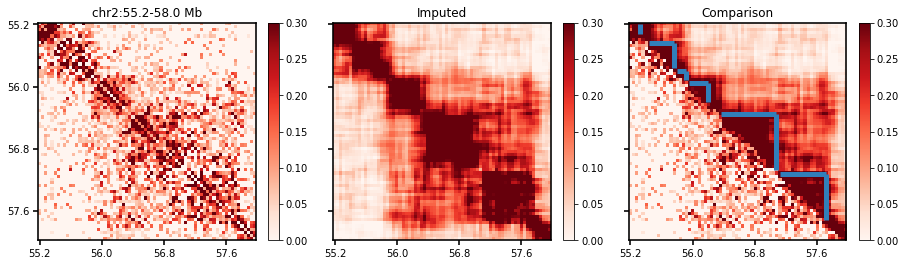

In [91]:
fgsize = (15, 4)
col_num = 3
title_l = ['', 'Imputed', 'Comparison']
tad_list_l = tad_list_all
bar_label = True
save_name = ''
PF.draw_multi_mat_compare_multi_row_with_TADs(st, ed, mat_list, mat_para_list, tad_list_l, bin_name_l, Chr, resolution, col_num,
                                             title_name_l=title_l, fgsize=fgsize, bin_size=20, save_name=save_name, ori='h', 
                                             bar_label = bar_label)

## For Psoas

In [92]:
cell_type = 'Psoas'
resolution = 40000
Chr = 'chr1'

In [93]:
hic_mat_psoas = {}
mat_file = data_add_tissue + '/' + 'Psoas_chr1_40kb_iced.mat'
chr_length = chr_size[Chr]
bin_name_use = TL.chr_cut(chr_length, Chr, resolution)
bin_num = len(bin_name_use)
mat_hic = TL.LoadHicMat(mat_file, bin_num, mat_type='dense')
while np.max(mat_hic) <= 1000:
    mat_hic = mat_hic * 10
#while np.max(mat_hic) > 10000:
    #mat_hic = mat_hic * 0.1
hic_mat_psoas[Chr] = mat_hic

In [94]:
# Run TADGATE

In [95]:
# Paramaters
graph_radius = 2
split_size = 'all'
device = device_gpu0 

layer_node1 = 500
layer_node2 = 100
lr = 0.001
weight_decay = 0.0001
num_epoch = 500
embed_attention = False

weight_use = 'Fix'
weight_rate = 3.5
weight_range = int(10000000 / resolution)

In [96]:
TADGATE_res_psoas= TADGATE_main.TADGATE_for_embedding(hic_mat_psoas, chr_size, resolution, graph_radius, split_size,  device, layer_node1,
                                                      layer_node2, lr, weight_decay, num_epoch, embed_attention = embed_attention, 
                                                      weight_use = weight_use, weight_range = weight_range, weight_rate = weight_rate,
                                                      target_chr_l = [])

For chr1
Hi-C map is splited into 1 sub-map
Build spatial network...
Get mask-matrix or weight-matrix...
For No.0 sub-map
Train TADGATE....


100%|██████████| 500/500 [00:45<00:00, 11.03it/s]


Total time 47.69221329689026s


In [97]:
# Call TADs

In [98]:
# Paramaters
bd_weight_list = [1.5, 1.5, 1, 1]
cluster_method = 'Mclust'
window_range = 4000000
wd_p = 5
dist = 3
pvalue_cut = 0.03
exp_length = 400000
length_cut = 3

In [99]:
TADGATE_tads_psoas = CT.TADGATE_call_TADs(TADGATE_res_psoas, chr_size, resolution, bd_weight_list, 
                                         cluster_method, window_range, wd_p, dist, pvalue_cut, 
                                         exp_length, length_cut = 3, contact_fold_cut = 2, zero_ratio_cut = 0.3, 
                                         target_chr_l = [])

For chr1
20% bins done!
20% bins done!
20% bins done!
20% bins done!
Running time 17.44520401954651s


In [100]:
# Compare original and imputed maps

In [101]:
mat_hic = copy.deepcopy(TADGATE_res_psoas[Chr]['mat_split'][0].X)
mat_imputed = copy.deepcopy(TADGATE_res_psoas[Chr]['result'][0]['mat_imputed_sym'])

In [102]:
st = 4550
ed = 4620
mat_hic_whole, mat_imputed_whole, mat_combine_whole = PF.get_hic_map_original_and_imputed_compare(st, ed, mat_hic, mat_imputed, 
                                                                                                  QN = False)

In [103]:
bin_name_l = list(TADGATE_res_psoas[Chr]['mat_split'][0].obs_names)
mat_list = [mat_hic_whole, mat_imputed_whole, mat_combine_whole]
mat_para_list = []
for i in range(3):
    mat_para_list.append({'color': 'Reds', 'range':[0, 0.45], 'diag': False, 'net': False, 'value_type':'real', 
                          'tad_color':'#317FBA', 'tad_upper':True, 'tad_lower':False, 'norm_mat':False})

In [104]:
df_tad_res = TADGATE_tads_psoas[Chr]['TADs'][0]
df_tad_res_only = df_tad_res[df_tad_res['type'] == 'domain']
df_tad_res_only = df_tad_res_only.reset_index(drop = True)

In [105]:
start_bin = 0
tad_list_all = [[], []]
TAD_l = TL.get_tad_list_in_target_ranges(st, ed, df_tad_res_only, resolution, start_bin, pos_type='bin')
tad_list_all.append(TAD_l)

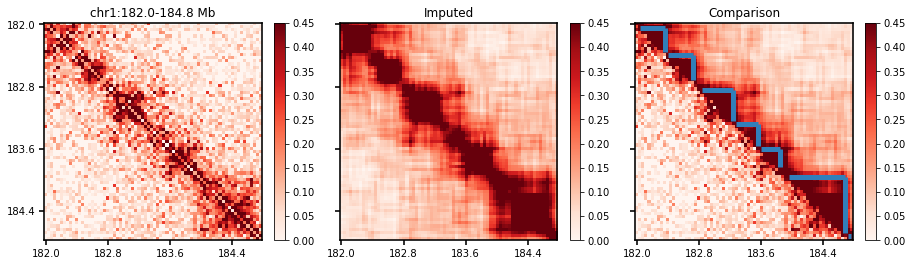

In [106]:
fgsize = (15, 4)
col_num = 3
title_l = ['', 'Imputed', 'Comparison']
tad_list_l = tad_list_all
bar_label = True
save_name = ''
PF.draw_multi_mat_compare_multi_row_with_TADs(st, ed, mat_list, mat_para_list, tad_list_l, bin_name_l, Chr, resolution, col_num,
                                             title_name_l=title_l, fgsize=fgsize, bin_size=20, save_name=save_name, ori='h', 
                                             bar_label = bar_label)